## Data Reduction Pipeline
Let's begin by importing some important modules.

In [ ]:
from spectral_cube import SpectralCube
import astropy.units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.gridspec import GridSpec
from astropy.wcs import WCS
from helpers import cdelt3, v_to_wavelen, get_uJy_cube
from moment0 import moment0
from specutils_fit import specutils_linear_fit, subtracted_cube
from scipy.interpolate import griddata

# SNR Mask
The following function masks all spaxels with SNR less than some threshold to 1e-32.

In [8]:
def snr_mask(fits_file, slice, center, threshold=3):
    '''
    Takes a slice, and based on ERR data, masks all spaxels with SNR < threshold to 1e-32.
    '''
    # Load cube and error cube, convert error cube to uJy
    hdul = fits.open(fits_file)
    cube = SpectralCube.read(fits_file,hdu=1)
    flux_array = hdul['SCI'].data
    error_array = hdul['ERR'].data
    
    wavelengths = cube.spectral_axis
    i_closest = np.argmin(np.abs(wavelengths - center))
    flux_slice = flux_array[i_closest,:,:]
    error_slice = error_array[i_closest,:,:]
    
    # Compute calibration error (5% of flux)
    calib_error = 0.05 * flux_slice
    
    # Total error
    sigma_total = np.sqrt(error_slice**2 + calib_error**2)

    # Compute SNR
    snr = (flux_slice / sigma_total) # flux_slice or slice.value?
    
    # Debugging
    # x,y=34,9
    # print(f"x,y={29},{28}")
    # print(f"Calibration error: {calib_error[y,x]}")
    # print(f"ERR: {error_slice[y,x]}")
    # print(f"Total error: {sigma_total[y,x]}")
    # print(f"Flux: {slice[y,x]}")
    # print(f"SNR: {snr[y,x]}")

    # Create output where SNR < 3 becomes 1e-32, others keep original
    masked_slice = np.where(snr < threshold, 1e-32 * u.uJy, slice)

    return masked_slice

# Manual Bad Spaxel Masking
The following function can be used to add a list of coordinates of "bad" coordinates to be masked out (i.e. changed to 1e-32).

In [9]:
def bad_spaxel_mask(lambda_0, slice_2d):
    bad_coords = []
    # [Fe II]
    if lambda_0 == 1.644 * u.um:
        bad_coords = [(17,30),(17,31),(17,35),(17,36),(18,30),(18,31),(18,33),(18,34),(18,35),(18,36),(19,30),(19,33),(20,30),(20,31),(20,33),(20,34),(21,33),(21,34),
                        (35,40),(36,40),(35,39),(36,39),(38,39),(39,39),(36,38),(37,38),(38,38),(39,38),(36,37),(37,37),(38,37),(39,37),(35,35),(36,35),(37,35),(38,35),(36,34),(37,34),(38,34)]
                        # (13,22),(14,22),(15,22),(16,22),(13,23),(14,23),(15,23),(16,23),(13,26),(14,26),(15,26),(16,26),(14,25),(13,27),(16,27),(12,28),(13,28),(14,28),(13,24)]
    elif lambda_0 == 2.803 * u.um:
        bad_coords = [(18,22),(19,22),(18,21),(19,21),(19,20),(20,20),(21,20),(22,20),(19,19),(20,19),(21,19),(18,17),(19,17),(20,17),(21,17),(18,16),(19,16),(20,16),(21,16)]
    
    for (x, y) in bad_coords:
        slice_2d[y, x] = 1e-32 * u.uJy # value to denote pixel to be interpolated
    
    return slice_2d

# Interpolation of Masked Spaxels
The following function interpolates masked spaxels (those with the value 1e-32) using SciPy.

In [10]:
def interpolate_pixels(slice, target_value=1e-32, method='linear', fallback='nearest'):
    """
    Interpolates pixels in a 2D array (units uJy) that are equal to a specific target value.
    
    Parameters:
        data2d : np.ndarray
            The 2D input array. Needs .value or it won't work
        target_value : float
            The pixel value to be treated as 'missing' and replaced via interpolation.
        method : str
            Primary interpolation method ('linear', 'nearest', 'cubic').
        fallback : str or None
            Fallback method to try if primary interpolation fails at a pixel.

    Returns:
        interpolated_map : np.ndarray
            The same shape as input, with target_value pixels replaced via interpolation.
    """
    flux_array = slice.value
    ny, nx = slice.shape
    yy, xx = np.indices((ny, nx))

    # Get all valid points (not NaN and not equal to target_value)
    valid_mask = (~np.isnan(flux_array)) & (flux_array != target_value)
    # print(valid_mask)
    known_points = np.stack([yy[valid_mask], xx[valid_mask]], axis=-1)
    known_values = flux_array[valid_mask]

    # Get all target pixels to interpolate
    target_mask = (flux_array == target_value)
    target_points = np.stack([yy[target_mask], xx[target_mask]], axis=-1)

    # Interpolate one pixel at a time
    for (yi, xi) in target_points:
        try:
            interp_value = griddata(
                known_points,
                known_values,
                np.array([[yi, xi]]),
                method=method
            )[0]
        except Exception:
            interp_value = np.nan

        # Try fallback if primary method failed or returned nan
        if (fallback is not None) and (np.isnan(interp_value)):
            try:
                interp_value = griddata(
                    known_points,
                    known_values,
                    np.array([[yi, xi]]),
                    method=fallback
                )[0]
            except Exception:
                interp_value = target_value  # fallback also failed, keep original

        # Replace the value in the copy
        flux_array[yi, xi] = interp_value

    return flux_array * u.uJy

# Full Pipeline
data_reduce() does the following:
1. Get the moment-0 map using moment0()
2. Compute the linear continuum using specutils_linear_fit()
3. Compute the subtracted slice 
4. Performs an SNR mask using snr_mask()
5. If applicable, masks out manually selected bad spaxels
6. Interpolates any masked out spaxels.


In [11]:
def data_reduce(fits_file, center, moment0_width, fit_width, lambda0=None):
    moment0_slice = moment0(fits_file, center, moment0_width)
    cont_slice = specutils_linear_fit(fits_file, center, fit_width, True) * moment0_width / cdelt3(fits_file)
    
    # Slice Subtraction
    slice = moment0_slice - cont_slice
    
    # Masks away all nonpositives to avoid log issues
    slice[slice <= 0] = 1e-32 * u.uJy
    
    # SNR Mask
    slice = snr_mask(fits_file, slice, center)
    
    # Manual bad spaxel masking
    if lambda0 is not None:
        slice = bad_spaxel_mask(lambda0, slice)
    
    # Interpolate marked spaxels
    slice = interpolate_pixels(slice)
    
    return slice # in uJy

# Plotting

In [42]:
def plot_data_reduce(fits_file, center, moment0_width, fit_width):
    lambda_obs = v_to_wavelen(center, (-77)* u.km/u.s) 
    lambda_obs = center
    print(f"Lambda_obs: {lambda_obs:.5f}")
    # slice = data_reduce(fits_file, lambda_obs, moment0_width, fit_width, center)
    slice = fits.open("../fits/slice2d5.fits")[0].data
    
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    im = ax.imshow(np.log10(slice), origin='lower', cmap='inferno', vmin=0, vmax=4)
    
    ax.set_title(f'Flux Density ($\lambda_0$={center})', fontsize=12)
    ax.set_xlabel('X pixel', fontsize=12)
    ax.set_ylabel('Y pixel', fontsize=12)
    
    cb = plt.colorbar(mappable=im)
    cb.set_label('$\log_{10} F_\lambda \, (\mu Jy)$', fontsize=12)
    
    # Peak brightness locations
    centers_x = [25.26613227,26.13168151, 27.0120717]
    centers_y = [33.59679364, 38.79008904, 44.07243022]
    
    # H2 Knots
    centers_x = [35, 21, 24]
    centers_y = [41, 46, 35]
    colors = ['blue', 'teal', 'palevioletred']
    
    ax.scatter(centers_x, centers_y, c=colors, marker='x', linewidths=3, edgecolors='black') # edgecolor not really working
    
    plt.tight_layout()
    plt.show()

Lambda_obs: 2.80250 um


/var/folders/_j/mydjhq1179jffd525zbvkvyh0000gn/T/ipykernel_70801/1179142500.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(centers_x, centers_y, c=colors, marker='x', linewidths=3, edgecolors='black') # edgecolor not really working


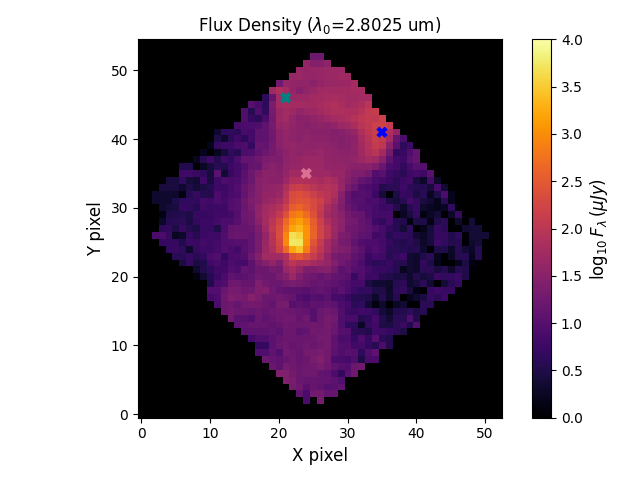

In [55]:
plt.rcParams['figure.dpi'] = 100
plot_data_reduce(fits_file = 'fits/5s3d.fits', center = 2.8025*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um)

# Save slice to directory

In [14]:
def write_slice(fits_file, center, moment0_width, fit_width, name='../fits/slice2d.fits'):
    cube = get_uJy_cube(fits_file)
    slice = data_reduce(fits_file, center, moment0_width, fit_width, center)
    
    # Get the 2D WCS (drops spectral axis)
    wcs2d = cube.wcs.sub(['longitude', 'latitude'])

    # Create a FITS header from WCS
    header = wcs2d.to_header()
    
    # Create HDU and save
    hdu = fits.PrimaryHDU(data=slice.value, header=header)
    hdu.writeto(name, overwrite=True)
    print(f"Reduced slice written to file as {name}")

In [15]:
# write_slice(fits_file = 'fits/5s3d.fits', center=2.8025*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um, name='fits/slice2d5.fits')

# Plot entire pipeline with intermediate paths

In [36]:
def plot_all(fits_file, center, moment0_width, fit_width):
    # lambda_obs = v_to_wavelen(center, (-29.802)* u.km/u.s) 
    lambda_obs = v_to_wavelen(center, (-77)* u.km/u.s) # velocity adjusted for jet blueshift
    # lambda_obs = center 
    print(f"Lambda_obs: {lambda_obs:.5f}")
    fig = plt.figure(figsize=(15, 4))

    # Create GridSpec: 1 row, 6 columns (moment0, linear fit, subtract, masks, interpolate, colorbar)
    gs = GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.1)

    # Subplots for the 3 maps
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    ax4 = fig.add_subplot(gs[4])
    
    # Colorbar axis
    cax = fig.add_subplot(gs[5])
    
    # Plot moment 0 map
    moment0_slice = moment0(fits_file, lambda_obs, moment0_width)
    im0 = ax0.imshow(np.log10(moment0_slice.value), origin='lower', cmap='inferno', vmin=0, vmax=3)
    ax0.set_title(f'Moment 0 Map', fontsize=13)
    
    
    # Plot the linear fit map
    cont_slice = specutils_linear_fit(fits_file, lambda_obs, fit_width, True) * moment0_width / cdelt3(fits_file)
    im1 = ax1.imshow(np.log10(cont_slice.value), origin='lower', cmap='inferno',vmin=0,vmax=3)
    ax1.set_title(f'Linear Continuum Fit', fontsize=13)
    
    # Plot the subtracted map
    slice = moment0_slice - cont_slice
    
    slice[slice <= 0] = 1e-32 * u.uJy
    im2 = ax2.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax2.set_title(f'Subtracted Residual', fontsize=13)
    
    # Plot the SNR & manually masked map
    # SNR Mask
    slice = snr_mask(fits_file, slice, lambda_obs)
    # Manual bad spaxel masking
    slice = bad_spaxel_mask(center, slice)
    im3 = ax3.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax3.set_title(f'SNR & Manual Masked', fontsize=13)
    
    # Interpolate marked spaxels
    slice = interpolate_pixels(slice)
    im4 = ax4.imshow(np.log10(slice.value), origin='lower', cmap='inferno', vmin = 0,vmax=3)
    ax4.set_title(f'Interpolated', fontsize=13)
    
    # Label axes
    ax0.set_ylabel('Y pixel', fontsize=13)
    for ax in [ax0,ax1,ax2,ax3,ax4]:
        ax.set_xlabel('X pixel', fontsize=13)
        ax.set_xticks(np.arange(0, 60, 10)) 
        ax.set_facecolor('black')
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_yticks([]) # removes extra tick labels
    
    # Add colorbar in its own axis
    fig.colorbar(im0, cax=cax, label=r'$\log_{10} F_\lambda \, (\mu Jy)$')
    # fig.suptitle(f"$\lambda_0$={center}", fontsize=14)
    fig.subplots_adjust(top=0.88, bottom=0.3)
    plt.tight_layout()
    plt.show()

Lambda_obs: 1.64358 um


        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        Use Spectrum instead. [specutils.spectra.spectrum]
        Use Spectrum instead. [specutils_fit]
        U

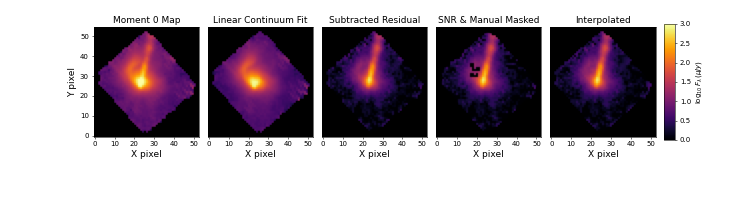

In [56]:
plt.rcParams['figure.dpi'] = 75 # Changes widget size
plot_all(fits_file = '../fits/4s3d.fits', center = 1.644*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um)